#### (Home credit competition 중심으로)
## 2.2 데이터 정제 - 탐색적 데이터 분석(EDA : Exploratory data analysis)
---
### 소스 및 데이터는 아래 kaggle을 참조하였습니다. 
* 캐글 주소 : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* 해당 커널의 한글 번역은 파파고와 구글을 활용하였습니다.
___

In [1]:
# 라이브러리 
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
# 데이터 셋
app_train = pd.read_csv('d:/Projects/Cp/input/application_train.csv')
app_test = pd.read_csv('d:/Projects/Cp/input/application_test.csv')

#### 탐색적 데이터 분석(EDA)

* EDA 수행 시 찾아야하는 것은 데이터 내의 이상(예외) 입니다.
> 잘못 입력한 숫자, 측정장비 오류, 유효하지만 극단적인 측정치
* 예외를 정량적으로 설명하는 한가지 방법은 describe 메소드를 사용하여 열의 통계를 살펴보는 것입니다.

#### 이상(예외)값 탐색

* DAYS_BIRTH(생일) 열의 숫자는 신청 당시의 고객의 연령과 관련하여 기록되기 때문에 음수이다. 
* 년으로 환산한 통계를 보려면 DAYS_BIRTH(새일) 열에 -1을 곱하고 년중 일수로 나눈 후 describe 메소드를 사용한다.
* DAYS_BIRTH(생일) 데이터는 상한/하한에 대한 이상치가 없어 적절하게 보인다. 

In [3]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

* DAYS_EMPLOYED(취업일)에 대한 통계를 보자.

In [4]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

* DAYS_EMPLOYED(취업일)을 년으로 환산 후 통계

In [5]:
(app_train['DAYS_EMPLOYED'] / 365).describe()

count    307511.000000
mean        174.835742
std         387.056895
min         -49.073973
25%          -7.561644
50%          -3.323288
75%          -0.791781
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

* DAYS_EMPLOYED(취업일) 최대 값은 1000년이다. 이는 타당한 값으로 보이지 않는다.

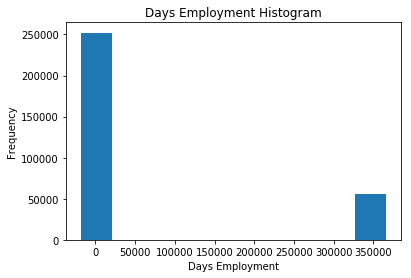

In [6]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

#### 취업일이 1000년인 이상치 고객들은 다른 고객들보다 채무불이행이 더 높거나 낮은 경향이 있는지 확인

* 취업일이 1000년인 고객과 그외 고객으로 데이터 발췌

In [7]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]

* 대출금 상환여부 컬럼(target) : 0 - 상환, 1 - 미상환
* 이상치에 해당하는 고객의 채무불이행율과 그외 고객의 채무불이행율 확인
* 이상치에 해당하는 고객 수 : 55,374

In [8]:
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


* 취업일(DAYS_EMPLOYED)이 1000년인 이상치 고객들은 다른 고객에 비해 채무불이행률이 낮다는 것을 확인
* 즉 취업일(DAYS_EMPLOYED)이 이상치에 해당하는 데이터는 무시할 수 없으므로 모델에 영향을 주지 않으면서 유용하게 쓸 수 있는 방법 모색  
___

* 해결책으로 테이터 셋에 이상치인 1000년에 해당하는 취업일(DAYS_EMPLOYED)을 NaN으로 만들고 비정상 여부를 나타내는 새로운 부울(Bool)형 열을 추가한다. 

#### 훈련용 데이터 셋에 부울(Bool)형 DAYS_EMPLOYED_ANOM 열(컬럼) 추가
* 취업일(DAYS_EMPLOYED)이 1000년인 경우 DAYS_EMPLOYED_ANOM에 True, 아닌 경우 False 값 설정

In [9]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

* 취업일(DAYS_EMPLOYED)이 1000년인 경우 NaN으로 변경

In [10]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

* 이상치가 제거된 취업일(DAYS_EMPLOYED)의 통계 및 그래프

In [11]:
app_train['DAYS_EMPLOYED'].describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

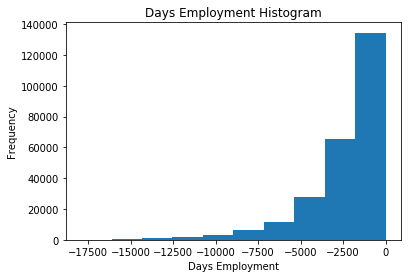

In [12]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

* 훈련용 데이터에 대해 수행하는 모든 작업은 테스트 데이터에도 적용합니다.
* 이상치를 나타내는 부울(Bool)형 새 열을 만들고 이상치에 해당하는 취업일(DAYS_EMPLOYED)이 1000년인 값을 np.Nan으로 변경 

In [13]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries
